# Total Variation for tomographic reconstruction

This notebook compares the following optimization algorithms for tomographic reconstruction with Total Variation (TV) regularization:
   - Douglas-Rachford (primal proximal splitting)
   - ADMM (dual proximal splitting), more precisely with the unconstrained formulation
   - Chambolle-Pock (semi-implicit primal-dual proximal splitting), more precisely the Pock-Chambolle preconditioned algorithm
   - FISTA (proximal gradient), with the "Optimized Gradient Method" step proposed by Donghwan-Fessler.

The optimization problem is
$$
\amin{\v x}{f(\v x) + g(\v x)} = \amin{\v x}{ \frac{1}{2}\norm{\v P \v x - \v d}_2^2  + \lambda \norm{\nabla \v x}_1 }
$$
where $\v P$ is the tomography projection operator, $\v d$ is the acquired sinogram, and $\nabla$ is the spatial gradient.  

When needed, the prox of $f$ is computed with a conjugate gradient, and the prox of $g$ is computed with Chambolle's dual algorithm.

$$
\renewcommand{\vec}{\boldsymbol} %boldsymbol or mathbf ?
\renewcommand{\v}{\vec}
\newcommand{\prox}[2]{\operatorname{prox}_{#1}{\left(#2\right)}}
\newcommand{\amin}[2]{\underset{#1}{\operatorname{argmin}} \; \left\{ #2 \right\} } 
\newcommand{\norm}[1]{\left\| #1 \right\|}
$$

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [44]:
from spire.utils import *
from spire.operators.image import *
from spire.operators.misc import *
from spire.algorithms.chambollepock import chambolle_pock_tv, chambolle_pock_tv_precond
from time import time
sol = None

Computation of the proximal map of 

$$
x \mapsto  \lambda /2 \left\| K x - d \right\|_2^2 
$$
(where $K$ is a linear operator of known adjoint, and $d$ is a known vector), using the conjugate gradient.

In [3]:
def prox_L2_CG(data, y, K, Kadj, Lambda, n_it, return_all=False):
	"""
	Proximal operator of ||K x - data||_2^2, i.e solution of
		Lambda/2 * ||K x - data||_2^2 + 1/2 ||x - y||_2^2
	Using a conjugate gradient solver.

	Parameters
	-----------
	data: data term
	y: dual variable where the prox is evaluated
	K: forward operator
	Kadj: adjoint of K
	Lambda: multiplicative parameter of the prox
	n_it: number of iterations
	"""

	# F(x) = Lambda/2 * ||K x - data||_2^2 + 1/2 ||x - y||_2^2
	# grad_F(x) = Lambda Kadj( K x - data) + x - y

	if return_all: energy = np.zeros(n_it)

	# Initial guess x0. Here we start from zero.
	kad = Kadj(data)
	x = kad*0 
	# Initial gradient
	# grad_F (x0) = -Lambda*Kadj(data) - y
	grad_F = -Lambda*kad - y
	# Initial conjugate direction
	# p0 = g0
	p = -np.copy(grad_F)

	for k in range(0, n_it):
		grad_F_old = grad_F
		Kadj_K_p = Kadj(K(p))
		# Line search
		# alpha_k = argmin_alpha F(x_{k+1} = x_k + alpha p_k)
		# dF/dalpha = grad_[F](x_{k+1}) d(x_{k+1})/dalpha
		# (1)  grad_F(x_{k+1}) = grad_F(x_k) + Lambda*alpha*Kadj*K*p_k + alpha p_k
		# (2)  d(x_{k+1})/dalpha = p_k
		# => 0 = p_k^T (grad_F(x_k) + Lambda*alpha*Kadj*K*p_k + alpha p_k)
		# => alpha = (-p_k^T grad_F(x_k)) / (Lambda*p_k^T Kadj K p_k  +  p_k^T p_k)
		num = -dot(p, grad_F)  # grad_F is grad_F(x_k)
		denom = Lambda * dot(p, Kadj_K_p) + dot(p, p) # perhaps merge in one dot for more perfs
		alpha = num/denom

		# Update variable
		# x_{k+1} = x_k + alpha_k p_k
		x = x + alpha*p

		# Update gradient
		grad_F = grad_F_old + Lambda*alpha*Kadj_K_p + alpha*p
		# Periodically re-calculate gradient
		# TODO
		
		# update beta (Polak-Ribiere rule)
		beta = dot(grad_F, grad_F - grad_F_old)/dot(grad_F_old, grad_F_old)

		# update conjugate direction
		p = -grad_F + beta*p

		if return_all:
			energy[k] = Lambda*0.5*norm2sq(K(x) - data) + 0.5*norm2sq(x - y)
			print("%d \t E = %e" % (k, energy[k]))
	if return_all:
		return energy, x
	else:
		return x



Computation of the proximal of Total Variation. It can be shown ([Chambolle2004], [Michel2011]) that it amounts to solving
$$
\amin{\v z}{
\norm{\text{div}\, \v z + \frac{\v y}{\lambda}}_2^2
+ i_{B_\infty} (\v z)
}
$$

It may also be solved with the Chambolle-Pock algorithm by chosing $\v K = \v I$

In [76]:
def prox_tv_fista(data, Lambda, n_it, return_all=False):
    Lip = 8.1 # (grad, div) operator norm = 8
    if return_all: en = np.zeros(n_it)
    x = np.zeros_like(gradient(data))
    y = np.zeros_like(x)
    for k in range(0, n_it):
        grad_y = -gradient(div(y) + data/Lambda)
        x_old = x
        x = proj_linf(y - (1.0/Lip)*grad_y)
        y = x + (k/(k+2.1))*(x - x_old) 
        # Calculate norms
        if return_all:
            fidelity = 0.5*norm2sq(div(x)+data/Lambda)
            if (k%10 == 0): # TODO: more flexible
                print("[%d] : fidelity %e" % (k,  fidelity))
            # More costly
            """
            v = data + Lambda*div(x)
            fidelity = norm2sq(v - data)*0.5
            tv = norm1(gradient(v))
            energy = fidelity + Lambda*tv
            en[k] = energy
            if (k%10 == 0): # TODO: more flexible
                print("[%d] : energy %e \t fidelity %e \t TV %e" % (k, energy, fidelity, tv))
            """
    v = data + Lambda*div(x)
    if return_all: return en, v
    else: return v

### Douglas-Rachford

$$
\left\{
\begin{aligned}
\v x_{k+1} &= \prox{\gamma f}{\v y_k} \\
\v y_{k+1} &= \v y_k  + \rho \left( \prox{\gamma g}{2 \v x_{k+1} - \v y_k } - \v x_{k+1} \right)
\end{aligned}
\right.
$$


In [5]:
def douglas_rachford(img, P, PT, beta, gamma, n_it=100, return_all=False):
	x = np.copy(PT(img))
	y = np.copy(x)
	u = 0*x
	rho = 1.9 # Peaceman-Rachford
	if return_all: energy = np.zeros(n_it)
	for k in range(n_it):
		# x_n = prox_{gamma f}(y_n)
		x = prox_L2_CG(img, y, P, PT, gamma, 30, return_all=False)
		# y_{n+1} = y + rho (prox_{gamma f_g} (2 x_n - y_n) - x_n)
		y = y + rho*(prox_tv_fista(2*x-y, gamma*beta, 80, return_all=False) - x)
		if return_all:
			l1 = norm1(gradient(x))
			l2 = norm2sq(P(x) - img)
			energy[k] = 0.5*l2 + beta*l1
		if (k % 10) == 0:
			print("%d \t L2 = %e" % (k, norm2sq(P(x) - img)))
	if return_all:
		return energy, x
	else:
		return x


### ADMM

Unconstrained problem:

$$
\amin{\v x_1, \v x_2}{ f(\v x_1) + g(\v x_2)  }
$$
The ADMM iteration is given by
$$
\left\{
\begin{aligned}
\v x_{k+1} &= \prox{\gamma f}{\v z_k - \v u_k} \\
\v z_{k+1} &= \prox{\gamma g}{\v x_{k+1} + \v u_k} \\
\v u_{k+1} &= \v u_k + \v x_{k+1} - \v z_{k+1}
\end{aligned}
\right.
$$

Constrained problem:
$$
\begin{aligned}
\amin{\v x_1, \v x_2}{ f(\v x_1) + g(\v x_2)  } \\
\text{s. t. } \; \v G \v x_1 = \v x_2
\end{aligned}
$$
the ADMM iteration is then
$$
\left\{ \begin{aligned}
\v x_{k+1} &= \amin{\v x}{  f(\v x) + \frac{\mu}{2} \norm{\v G \v x - \v z_k - \v u_k}_2^2   }   \\
\v z_{k+1} &= \prox{g/\mu}{ \v G \v x_{k+1} - \v u_k  }      \\
\v u_{k+1} &= \v u_k - \v G \v x_{k+1} + \v z_{k+1}
\end{aligned} \right.
$$

In [152]:
# TODO: warm start for prox_L2, i.e start with an initial solution in prox_L2.
# The initial solution is the previous x_k of the outer loop
def admm_unconstrained(img, P, PT, beta, Lambda, n_it=100, return_all=False):
	x = np.copy(PT(img))
	z = np.copy(x)
	u = 0*x
	if return_all: energy = np.zeros(n_it)
	for k in range(n_it):
		# x_{k+1} = prox_{Lambda f} (z_k - u_k)
		x = prox_L2_CG(img, z-u, P, PT, Lambda, 10, return_all=False) # 40
		# z_{k+1} = prox_{Lambda g} (x_{k+1} + u_k)
		z = prox_tv_fista(x + u, Lambda*beta, 20, return_all=False) # 40
		# u_{k+1} = u_k + x_{k+1} - z_{k+1}
		u = u + x - z
        
		# test - progressively decrease step for a faster cv
		#if (k > 0) and (k % 10) == 0:
		#		Lambda = Lambda / 2.
		#######
        
		if return_all:
			l1 = norm1(gradient(x))
			l2 = norm2sq(P(x) - img)
			energy[k] = 0.5*l2 + beta*l1
		if (k % 10) == 0:
			print("%d \t Energy %e \t fid %e \t TV %e " % (k, energy[k], l2, l1))
	if return_all:
		return energy, x
	else:
		return x # x and z converge to eachother, but not u


## Tomography operators

In [7]:
from spire.tomography.tomography import AstraToolbox
ph = np.load("data/Brain256.npz")["data"]
tomo = AstraToolbox(ph.shape[0], 40)
si = tomo.proj(ph)

P = lambda x : tomo.proj(x)
PT = lambda x : tomo.backproj(x)

## Algorithms comparison


In [69]:
gamma = 1.
ed, rd = douglas_rachford(si, P, PT, 10.0, gamma, n_it=101, return_all=True)

0 	 L2 = 1.315018e+12
10 	 L2 = 1.586156e+11
20 	 L2 = 1.922436e+10
30 	 L2 = 2.315242e+09
40 	 L2 = 2.781754e+08
50 	 L2 = 3.414523e+07
60 	 L2 = 4.971999e+06
70 	 L2 = 1.058753e+06
80 	 L2 = 4.542485e+05
90 	 L2 = 4.142712e+05
100 	 L2 = 3.984434e+05


In [130]:
# figure(); plot(ed)

In [131]:
# ims(rd, cmap="gray")

In [153]:
Lambda = 5e-2
t0 = time()
ea, ra =  admm_unconstrained(si, P, PT, 10., Lambda, n_it=501, return_all=True)
ta = (time()-t0)*1.

0 	 Energy 2.613461e+14 	 fid 5.226919e+14 	 TV 1.512737e+07 
10 	 Energy 2.383370e+07 	 fid 3.209825e+07 	 TV 7.784577e+05 
20 	 Energy 2.383103e+07 	 fid 3.209433e+07 	 TV 7.783864e+05 
30 	 Energy 2.383070e+07 	 fid 3.209374e+07 	 TV 7.783827e+05 
40 	 Energy 2.383063e+07 	 fid 3.209358e+07 	 TV 7.783835e+05 
50 	 Energy 2.383061e+07 	 fid 3.209356e+07 	 TV 7.783836e+05 
60 	 Energy 2.383062e+07 	 fid 3.209357e+07 	 TV 7.783836e+05 
70 	 Energy 2.383067e+07 	 fid 3.209368e+07 	 TV 7.783836e+05 
80 	 Energy 2.383063e+07 	 fid 3.209359e+07 	 TV 7.783836e+05 
90 	 Energy 2.383062e+07 	 fid 3.209358e+07 	 TV 7.783836e+05 
100 	 Energy 2.383066e+07 	 fid 3.209365e+07 	 TV 7.783836e+05 
110 	 Energy 2.383060e+07 	 fid 3.209353e+07 	 TV 7.783836e+05 
120 	 Energy 2.383062e+07 	 fid 3.209358e+07 	 TV 7.783836e+05 
130 	 Energy 2.383066e+07 	 fid 3.209364e+07 	 TV 7.783836e+05 
140 	 Energy 2.383062e+07 	 fid 3.209356e+07 	 TV 7.783836e+05 
150 	 Energy 2.383066e+07 	 fid 3.209364e+07 	 TV 7

<IPython.core.display.Javascript object>


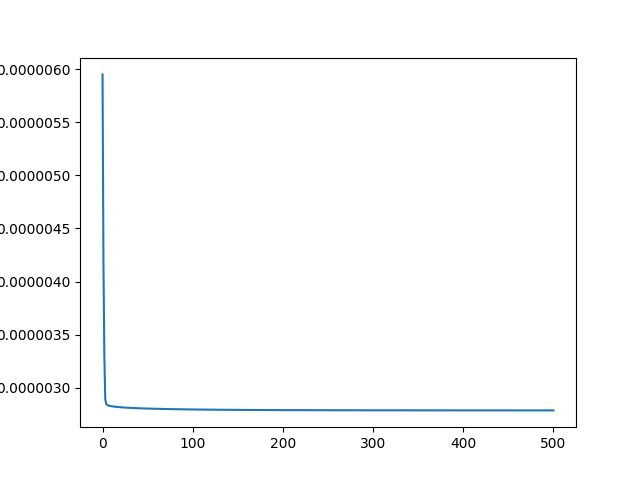

In [138]:
figure(); plot(np.log(ea)/ea.min())

<IPython.core.display.Javascript object>


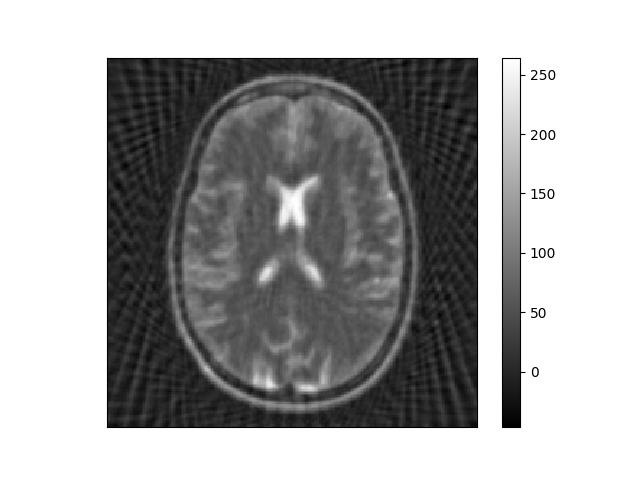

([], <a list of 0 Text yticklabel objects>)

In [154]:
ims(ra, cmap="gray"); plt.xticks([]); plt.yticks([])

## Chambolle-Pock

In [127]:
t0 = time()
ec, rc = chambolle_pock_tv_precond(si, P, PT, 10., n_it=501, return_all=True)
tc = (time()-t0)*1.

[0] : energy 6.580313e+11 	 fidelity 6.580313e+11 	 TV 0.000000e+00
[10] : energy 4.817296e+09 	 fidelity 4.810106e+09 	 TV 7.189290e+05
[20] : energy 2.440603e+09 	 fidelity 2.428270e+09 	 TV 1.233303e+06
[30] : energy 9.123018e+08 	 fidelity 9.025809e+08 	 TV 9.720908e+05
[40] : energy 7.283939e+08 	 fidelity 7.224863e+08 	 TV 5.907664e+05
[50] : energy 5.168351e+08 	 fidelity 5.101096e+08 	 TV 6.725434e+05
[60] : energy 3.139824e+08 	 fidelity 3.054828e+08 	 TV 8.499563e+05
[70] : energy 2.695818e+08 	 fidelity 2.610559e+08 	 TV 8.525901e+05
[80] : energy 1.671833e+08 	 fidelity 1.599341e+08 	 TV 7.249125e+05
[90] : energy 1.291746e+08 	 fidelity 1.225635e+08 	 TV 6.611110e+05
[100] : energy 9.594587e+07 	 fidelity 8.905773e+07 	 TV 6.888144e+05
[110] : energy 6.464628e+07 	 fidelity 5.748005e+07 	 TV 7.166232e+05
[120] : energy 5.352184e+07 	 fidelity 4.652820e+07 	 TV 6.993632e+05
[130] : energy 3.821630e+07 	 fidelity 3.160036e+07 	 TV 6.615943e+05
[140] : energy 2.970049e+07 	 f

<IPython.core.display.Javascript object>


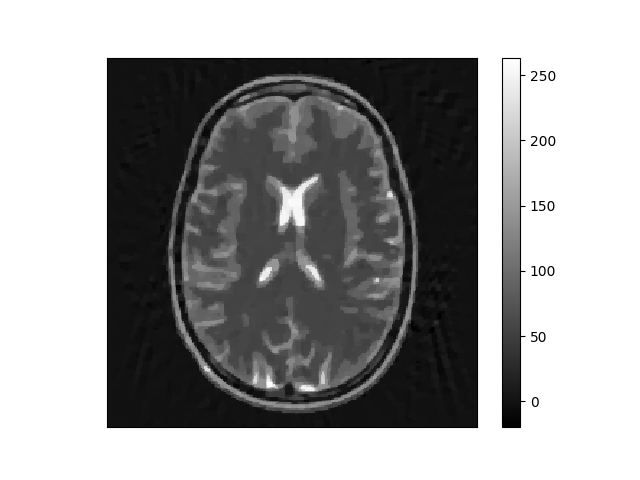

([], <a list of 0 Text yticklabel objects>)

In [129]:
ims(rc, cmap="gray"); plt.xticks([]); plt.yticks([])

## FISTA

In [118]:
def fista_tv(data, K, Kadj, Lambda, Lip=None, n_it=100, return_all=True):
    if Lip is None:
        print("Warn: Lipschitz constant not provided, computing it with 20 iterations")
        Lip = power_method(K, Kadj, data, 20)**2 * 1.2
        print("Lip = %e" % Lip)

    if return_all: en = np.zeros(n_it)
    x = np.zeros_like(Kadj(data))
    y = np.zeros_like(x)
    t = 1.
    for k in range(0, n_it):
        grad_y = Kadj(K(y) - data)
        x_old = x
        x = prox_tv_fista(y - (1.0/Lip)*grad_y, Lambda/Lip, 40, return_all=False)       
        
        t_old = t
        t = 0.5*(1 + sqrt(1+4*t*t))
        # Beck-Teboulle
        # y = x + ((t_old - 1)/t) * (x - x_old) 
        # Fessler
        y = x + ((t_old - 1)/t) * (x - x_old)  + t_old/t * (x - y)
                
        # Calculate norms
        if return_all:
            fidelity = 0.5*norm2sq(K(x)-data)
            l1 = norm1(gradient(x))
            energy = fidelity + Lambda*l1
            en[k] = energy
            if (k%10 == 0): # TODO: more flexible
                print("[%d] : energy %e \t fidelity %e \t L1 %e" % (k, energy, fidelity, l1))
    if return_all: return en, x
    else: return x


In [119]:
t0 = time()
ef, rf = fista_tv(si, P, PT, 10., n_it=251, return_all=True)
tf = (time()-t0)*1.

Warn: Lipschitz constant not provided, computing it with 20 iterations
Lip = 1.175646e+04
[0] : energy 6.426576e+10 	 fidelity 6.426548e+10 	 L1 2.772145e+04
[10] : energy 6.546204e+08 	 fidelity 6.498735e+08 	 L1 4.746925e+05
[20] : energy 4.700807e+07 	 fidelity 3.880990e+07 	 L1 8.198174e+05
[30] : energy 2.482615e+07 	 fidelity 1.637672e+07 	 L1 8.449432e+05
[40] : energy 1.270678e+07 	 fidelity 4.860965e+06 	 L1 7.845819e+05
[50] : energy 1.026232e+07 	 fidelity 2.555839e+06 	 L1 7.706477e+05
[60] : energy 8.822868e+06 	 fidelity 1.126798e+06 	 L1 7.696069e+05
[70] : energy 8.245104e+06 	 fidelity 6.461932e+05 	 L1 7.598911e+05
[80] : energy 7.892228e+06 	 fidelity 4.027360e+05 	 L1 7.489492e+05
[90] : energy 7.644519e+06 	 fidelity 2.553469e+05 	 L1 7.389172e+05
[100] : energy 7.481890e+06 	 fidelity 1.808899e+05 	 L1 7.301000e+05
[110] : energy 7.343895e+06 	 fidelity 1.228230e+05 	 L1 7.221072e+05
[120] : energy 7.235470e+06 	 fidelity 9.246517e+04 	 L1 7.143004e+05
[130] : ene

In [120]:
def plotlog(D, absmin=True, legend=None, labels=None, markers=None, lw=1.5):
    plt.figure()
    lim = np.inf
    for k,d in enumerate(D):
        if absmin: lim = min(lim, d.min())
        else: lim = d.min()
        if markers:
            plt.plot(np.log10((d-lim)/(d[0]-lim)), markers[k], lw=lw)
        else:
            plt.plot(np.log10((d-lim)/(d[0]-lim)), lw=lw)
    if legend: plt.legend(legend)
    if labels:
        xlabel, ylabel = labels
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.show()
    

<IPython.core.display.Javascript object>


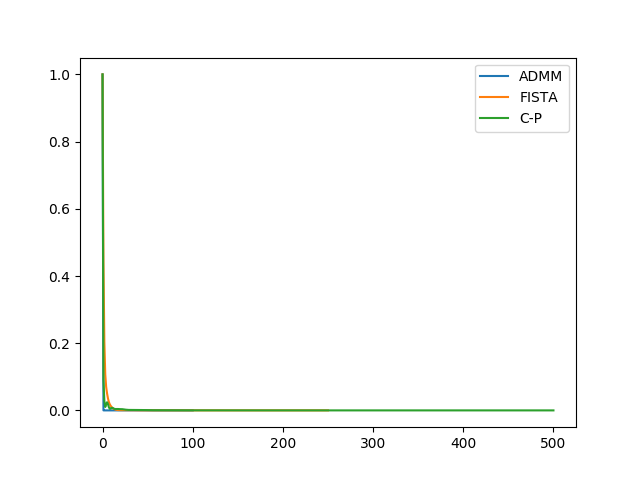

<IPython.core.display.Javascript object>


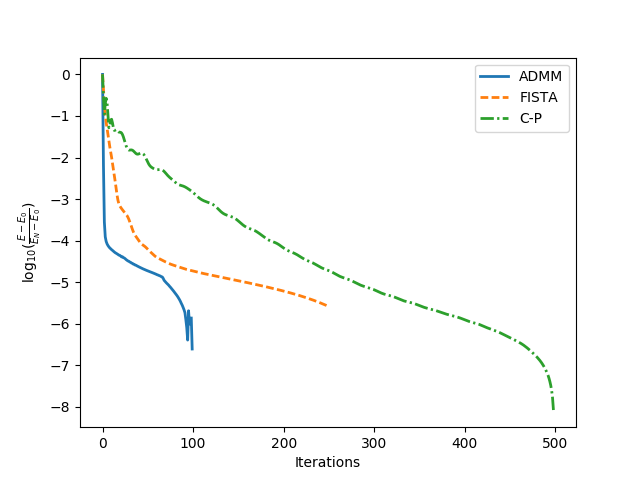

In [121]:
figure(); plot(ea/ea[0]); plot(ef/ef[0]);  plot(ec/ec[0]); plt.legend(["ADMM", "FISTA", "C-P"])
plotlog([ea[1:], ef, ec[1:]], 
        legend=["ADMM", "FISTA", "C-P"], 
        labels=["Iterations", "$\log_{10}(\\frac{E - E_0}{E_N-E_0})$"],
        markers=["-", "--", "-."], 
        lw=2.
       )

<IPython.core.display.Javascript object>


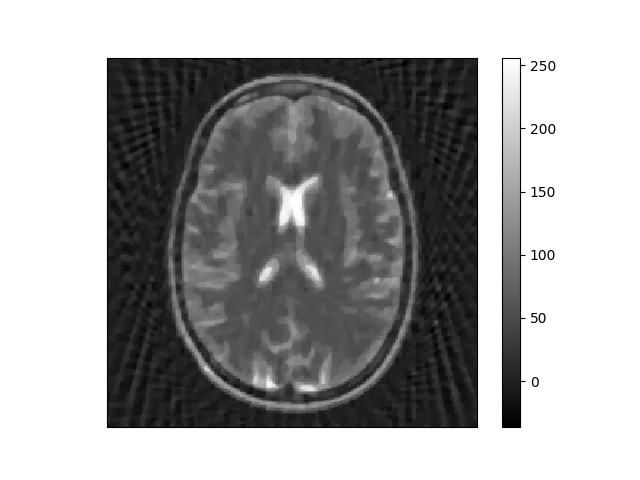

([], <a list of 0 Text yticklabel objects>)

In [124]:
ims(rf, cmap="gray"); plt.xticks([]); plt.yticks([])

In [156]:
# Compute the ground-truth solution with 2000 iterations of C-P 
if sol is None: sol = chambolle_pock_tv_precond(si, P, PT, 10., n_it=2001, return_all=False)

#ref = ph
ref = sol
print("FISTA: %d iterations, MSE = %e, Time = %.1f s" % (ef.shape[0], norm2sq(rf -ref), tf))
print("C-P: %d iterations, MSE = %e, Time = %.1f s" % (ec.shape[0], norm2sq(rc -ref), tc))
print("ADMM: %d iterations, MSE = %e, Time = %.1f s" % (ea.shape[0], norm2sq(ra -ref), ta))

FISTA: 251 iterations, MSE = 7.334627e+06, Time = 23.6 s
C-P: 501 iterations, MSE = 6.087826e+05, Time = 4.4 s
ADMM: 501 iterations, MSE = 1.181029e+07, Time = 44.7 s


# Conclusion 

From these simulations, it appears that 
   1. Regarding the convergence rate: ADMM > FISTA > Chambolle-Pock
   2. Regarding the cost per iteration: cost(ADMM) > cost(FISTA) > cost(Chambolle-Pock) 
   3. It is important to have an accurate proximal computation for ADMM and FISTA. Not using enough iterations in the inner loops leads to a reconstruction without the "compressed sensing" property (i.e subsampling artefacts).
   4. As commonly observed, ADMM provides an extremely fast convergence in the beginning of the optimization process, then is slower to reach an accurate solution. For imaging applications, it can make sense to use a few iterations if only an approximate solution is needed.
   5. Considering the trade-off between convergence rate, accuracy and time-per-iteration, it seems that **C-P is the better algorithm to use in this case**.
 
(1) and (2) are easy to justify. Computing the prox of $f$ in ADMM is equivalent to inverting the (regularization) Hessian at each iteration, providing a second-order method. FISTA uses the fact that $f$ is differentiable for the computation of the "gradient step". Chambolle-Pock does not use any assumption, except that $\v P$ is a positive operator for using its preconditioned version. Computing a prox at each iteration is costly, except for C-P where the problem is reformulated to only involve matrix-vector multiplications at each iteration.

The conclusion (5) would certainly be different in other applications. For example, in deblurring or inpainting applications, the prox of $f$ can be computed in one step. With orthogonal Wavelet regularization, the prox of $g$ is also very simple to compute. 



<IPython.core.display.Javascript object>


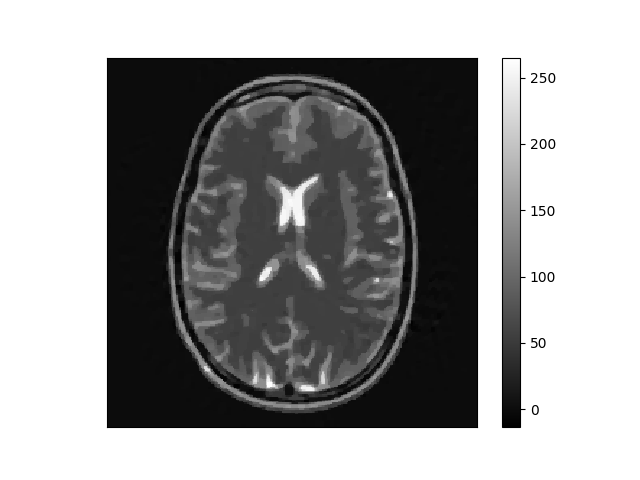

([], <a list of 0 Text yticklabel objects>)

In [133]:
ims(sol, cmap="gray"); plt.xticks([]); plt.yticks([])